### **Fine tuning the pytorch ssd300_vgg16 network with pre-trained weights on the VOC_2011 person layout datase**t



In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as T
from torchvision.models.detection import _utils
from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.datasets import CocoDetection
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import xml.etree.ElementTree as ET
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import pandas as pd

Setting device to cuda if availiable. Select Runtime-> change runtime type -> t4 gpu

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Importing the ssd300_vgg16 and fine-tuning it with the new number of classes and size of the VOC 2007 dataset.Adjust size and number of classes depending on the number of labels according to your dataset

In [ ]:
model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
def fine_tune_model(model, num_classes, size, device):
    #Changing the classification head to the number of classes
    in_channels = _utils.retrieve_out_channels(model.backbone, (size,size ))
    num_anchors = model.anchor_generator.num_anchors_per_location()
    model.head.classification_head = SSDClassificationHead(
        in_channels=in_channels,
        num_anchors=num_anchors,
        num_classes=num_classes,

    )
    model.transform.min_size = (size,)
    model.transform.max_size = size
    model = model.to(device)
    return model
model = fine_tune_model(model, 4, 300, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Importing VOC dataset. defining class names wich are 4 including background, resizing the image to 300, 300 and defining a custom dataset to convert the dataset to the correct format ssd300 expects

In [ ]:
!git clone https://github.com/ahmedjlidi/Demo

Cloning into 'Demo'...
remote: Enumerating objects: 34369, done.
remote: Total 34369 (delta 0), reused 0 (delta 0), pack-reused 34369 (from 1)
Receiving objects: 100% (34369/34369), 1.59 GiB | 23.97 MiB/s, done.
Resolving deltas: 100% (14038/14038), done.
Updating files: 100% (34470/34470), done.


Reading the image folder

In [ ]:
path = '/content/Demo/Voc/TrainVal/VOCdevkit/VOC2011/ImageSets/Layout/train.txt'
data = pd.read_csv(path, sep='\t', header=None, names=['img_name', 'value'])
print(data.shape)
img_list =[]
for img in data['img_name']:
    img_list.append(str(img).split(' ')[0])

(425, 2)


Reading the xml files and converting the needed parts to dictionaries

In [ ]:
class ImageClass():
    def __init__(self, img_list, path):
        self.img_list = img_list
        self.path = path
        self.Imageset = []
        self.annotations = {}

        for img_name in self.img_list:
            img_path = os.path.join(self.path, img_name + '.jpg')
            if os.path.exists(img_path):
                try:
                    img = Image.open(img_path)
                    self.Imageset.append(img)
                except Exception as e:
                    print(f"Error loading image {img_name}: {e}")
            else:
                print(f"Image {img_name} not found")

    def load_annotations(self, img_list, anno_path):
        for img_name in img_list:
            xml_path = os.path.join(anno_path, img_name + '.xml')  # Add XML extension
            if os.path.exists(xml_path):
                try:
                    tree = ET.parse(xml_path)  # Parse the XML file
                    root = tree.getroot()
                    annotation = self.parse_annotation(root)
                    self.annotations[img_name] = annotation
                except Exception as e:
                    print(f"Error parsing XML for {img_name}: {e}")
            else:
                print(f"Annotation file for {img_name} does not exist at {xml_path}")

    def parse_annotation(self, root):
        annotation = {}
        for child in root:
            # Handle the 'object' element (which can be multiple)
            if child.tag == 'object':
                if 'object' not in annotation:
                    annotation['object'] = []
                annotation['object'].append(self.parse_annotation(child))
            # Handle the 'part' element (which can be multiple)
            elif child.tag == 'part':
                if 'part' not in annotation:
                    annotation['part'] = []
                annotation['part'].append(self.parse_annotation(child))
            # Recursively parse elements with children
            elif len(child) > 0:
                annotation[child.tag] = self.parse_annotation(child)
            # Parse elements without children
            else:
                annotation[child.tag] = child.text
        return annotation

Imageset = ImageClass(img_list, '/content/Demo/Voc/TrainVal/VOCdevkit/VOC2011/JPEGImages/')
Imageset.load_annotations(img_list,'/content/Demo/Voc/TrainVal/VOCdevkit/VOC2011/Annotations/')

Defining classes dataset and train loader

In [ ]:
classes = {
    'background': 0,
    'head' : 1,
    'hand': 2,
    'foot': 3,
}



def collate_fn(batch):
    images, targets = zip(*batch)

    images = torch.stack([img for img in images], dim=0)


    targets = [
        {'boxes': t['boxes'], 'labels': t['labels']} for t in targets
    ]

    return images, targets

class ImageDataset(Dataset):
    def __init__(self, Imageset,img_list,  annotations, transform = None):
        self.Imageset =Imageset
        self.annotations = annotations
        self.processed_annonations = []
        self.corrupt_indicies = []
        self.dict_annonations = self.createAnnonations()
        self.clean()
        self.img_list = img_list
        self.transform = transform


    def createAnnonations(self):
        dict_tensors_list = []
        annonation = None
        for i in range(len(img_list)):
            flag = False
            annonation = self.annotations[img_list[i]]

            boundboxes = []
            labels = []

            if 'object' in annonation:
                for obj in annonation['object']:
                    if 'part' in obj:
                        for element in obj['part']:
                            boundboxes.append(element['bndbox'])
                            labels.append(element['name'])
                    else:
                        flag = True
                        break

            if(flag):
                flag = False
                self.corrupt_indicies.append(i)
                continue
            convert_to_float = lambda x: float(x)

            tensor_boxes = torch.tensor([])
            tensor_labels = torch.tensor([])
            for boundbox, label in zip(boundboxes, labels):
                temp_cord = []
                for cord in boundbox.values():
                    temp_cord.append(convert_to_float(cord))
                temp_cord = np.array(temp_cord)
                temp_cord = torch.tensor(temp_cord).unsqueeze(0).float()
                tensor_boxes = torch.cat((tensor_boxes, temp_cord), dim= 0)

                int_label = classes[label]
                temp_cord = torch.tensor(int_label, dtype = torch.long).unsqueeze(0)
                tensor_labels = torch.cat((tensor_labels, temp_cord), dim= 0)
            # print(temp_cord)

            dict_tensor = {}
            dict_tensor['boxes'] = tensor_boxes
            dict_tensor['labels'] = tensor_labels

            dict_tensors_list.append(dict_tensor)

        return dict_tensors_list


    def __getitem__(self, index):
        if index >= len(self.Imageset):
            raise IndexError(f"Index {index} out of range")
        img = self.Imageset[index]
        original_width, original_height = img.size

        if self.transform is not None:
            img = self.transform(img)

        target = self.dict_annonations[index]

        new_width, new_height = 300, 300
        width_scale = new_width / original_width
        height_scale = new_height / original_height

        if(index not in self.processed_annonations):
            target['boxes'][:, [0, 2]] *= width_scale
            target['boxes'][:, [1, 3]] *= height_scale
            self.processed_annonations.append(index)

        return img, target
    def __len__(self):
        return len(self.Imageset)

    def clean(self):
        filtered_elements = [elem for i, elem in enumerate(self.Imageset) if i not in self.corrupt_indicies]
        self.Imageset = filtered_elements

In [ ]:
transform = T.Compose([
    T.Resize((300, 300)),
    T.ToTensor()
])
test_dataset = ImageDataset(Imageset.Imageset, img_list, Imageset.annotations, transform)
train_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, drop_last=True, collate_fn= collate_fn)

Inspecting some data

In [ ]:
img = train_loader.dataset[8][0]
box = train_loader.dataset[8][1]

Testing an image to see if data loader works fine

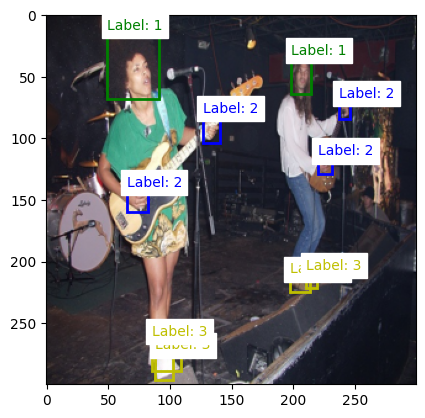

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img = train_loader.dataset[8][0]
box = train_loader.dataset[8][1]
img = (img.permute(1, 2, 0).detach().numpy())

def imshow_with_boxes(image, target):
    """
    Function to display a PIL image alongside its bounding boxes and labels.

    Parameters:
        image (PIL.Image): The image in PIL format.
        target (dict): A dictionary containing 'boxes' and 'labels' tensors.
                       - 'boxes': Tensor of shape (N, 4) where N is the number of boxes.
                       - 'labels': Tensor of shape (N,) corresponding to the labels of each box.
    """

    # Plot the image
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Extract the bounding boxes and labels
    boxes = target['boxes']
    labels = target['labels']

    # Define color map for different labels (optional)
    colors = ['r', 'g', 'b', 'y', 'm']  # Add more colors if you have more labels

    # Iterate through all bounding boxes and labels
    for i, box in enumerate(boxes):
        # Extract box coordinates (xmin, ymin, xmax, ymax)
        xmin, ymin, xmax, ymax = box

        # Create a rectangle patch
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor=colors[int(labels[i]) % len(colors)], facecolor='none')

        # Add the rectangle to the plot
        ax.add_patch(rect)

        # Optionally add label text near the box
        ax.text(xmin, ymin - 5, f'Label: {int(labels[i])}', color=colors[int(labels[i]) % len(colors)], fontsize=10, backgroundcolor='white')

    plt.show()


imshow_with_boxes(img, box)


Function to convert input to device ( either gpu or cpu )

In [ ]:
def convert_input_to_device(images, targets, device):
    for i in range(len(targets)):
        for target in targets:
            for key in target.keys():
                targets[i][key] =  targets[i][key].to(device).long()
    images = images.to(device)
    return images, targets


Testing random input

In [ ]:
test_img = torch.randn(1, 3, 300, 300)
test_target = [{'boxes': torch.tensor([[100, 100, 200, 200]]), 'labels': torch.tensor([1])}]


test_img, test_target = convert_input_to_device(test_img, test_target, device)
model(test_img, test_target)

{'bbox_regression': tensor(2.2653, device='cuda:0', grad_fn=<DivBackward0>),
 'classification': tensor(14.5580, device='cuda:0', grad_fn=<DivBackward0>)}

The training loop will be in mini batches. loss is calculated within the network

In [ ]:
def train(epochs, optimizer):
    model.train()
    total_loss= []
    for i in range(epochs):
        for images, targets in train_loader:
            images, targets = convert_input_to_device(images, targets, device)

            #In training mode, network expects image and target as inputs
            #it will return a loss dictionary

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())

            # Backward pass and optimization
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            loss = losses.item()
            total_loss.append(loss)
        print(f"Epoch: {i+1}, Total Loss: {np.mean(total_loss)}")
        total_loss.clear()

Training for few epochs is enough ( 10 or 15). Choosing a low learning rate is important to avoid exploading gradient

In [ ]:
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train(num_epochs, optimizer)

Function to visualize output

In [ ]:
def visualize_output(input_image, model_output, class_names, threshold=0.5):
    """
    Visualize the input image with the model's predicted bounding boxes.

    Parameters:
        input_image (Tensor): The input image tensor (C, H, W).
        model_output (dict): The model output containing bounding boxes and scores.
        class_names (list): List of class names.
        threshold (float): Score threshold to filter bounding boxes.
    """

    # Extract bounding boxes and scores
    boxes = model_output[0]['boxes'].detach().cpu().numpy()
    labels = model_output[0]['labels'].detach().cpu().numpy()
    scores = model_output[0]['scores'].detach().cpu().numpy()

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img)

    # Plot each bounding box with a label if score is above the threshold
    for i in range(len(scores)):
        if scores[i] > threshold:
            box = boxes[i]
            label = int(labels[i])
            score = scores[i]

            # Draw bounding box
            rect = patches.Rectangle(
                (box[0], box[1]), box[2] - box[0], box[3] - box[1],
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)

            # Annotate label and score
            plt.text(
                box[0], box[1], f'{class_names[label]}: {score:.2f}',
                color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5)
            )

    plt.show()


Function to crop resulting image

In [ ]:
def crop_img(input_image, model_output, class_names, threshold=0.5):
    """
    Visualize the input image with the model's predicted bounding boxes.

    Parameters:
        input_image (Tensor): The input image tensor (C, H, W).
        model_output (dict): The model output containing bounding boxes and scores.
        class_names (list): List of class names.
        threshold (float): Score threshold to filter bounding boxes.
    """

    # Extract bounding boxes and scores
    boxes = model_output[0]['boxes'].detach().cpu().numpy()
    labels = model_output[0]['labels'].detach().cpu().numpy()
    scores = model_output[0]['scores'].detach().cpu().numpy()


    # Plot each bounding box with a label if score is above the threshold
    for i in range(len(scores)):
        if scores[i] > threshold:
            box = boxes[i]
            label = int(labels[i])
            score = scores[i]

            if (class_names[label] =='head'):
                cropped_image = input_image[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
                return cropped_image

Function to calculate Intersection over union score

In [ ]:
def calculate_iou(box1, box2):
    # Calculate the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate the area of intersection
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Calculate the area of both the prediction and ground-truth rectangles
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Calculate the intersection over union (IoU)
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

Testing The model's Intersection over union score. Anything above 0.5 is acceptable

In [ ]:
total_score = []
for images, targets in train_loader:
    model.eval()
    images, targets = convert_input_to_device(images, targets, device)
    with torch.no_grad():
        outputs = model(images)
    total_score.append(calculate_iou(outputs[0]['boxes'][0].cpu().numpy(), targets[0]['boxes'][0].cpu().numpy()))

msg = None
if(np.mean(total_score) > 0.5):
    msg = "Model is acceptable"
elif np.mean(total_score) > 0.7:
    msg = "Model is accurate"
elif np.mean(total_score) < 0.3:
    msg = "Model is not acceptable"

print(f"Intersection over union score: {np.mean(total_score)}. {msg}")

Grabbing random image from the dataloader and testing it. (In eval mode, network expects 1 input the image)

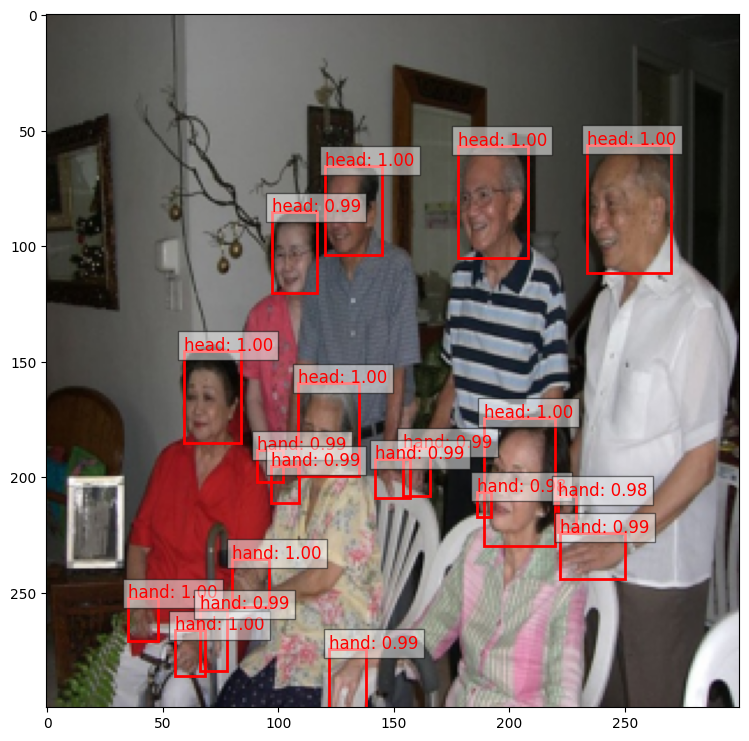

In [ ]:
class_names = []
for key in classes.keys():
    class_names.append(key)
img = None
img = test_dataset[120][0]

input = img
input = input.unsqueeze(0)
input = input.to(device)

img = img.detach().cpu().numpy()
img = img.transpose(1, 2, 0)

model.eval()
output = model(input)
visualize_output(img, output,class_names, 0.5)

Testing a sample image. To upload image, select files -> upload

In [ ]:
path_to_img = "Path_to_img"

data = Image.open(path_to_img)

input = T.ToTensor()(data)
input = input.unsqueeze(0)
input = input.to(device)

img = input.detach().cpu().numpy()
img = img.squeeze()
img = img.transpose(1, 2, 0)


model.eval()
output = model(input)

visualize_output(img, output,class_names, 0.5)

plt.imshow(crop_img(img, output,class_names, 0.5))

If satisfied with the perfomance, save the model

In [ ]:
name = "layout.pth"
torch.save(model, name)

We can also use the model to process videos in mp4 format

In [ ]:
def process_video(path_video, model):
  cap = cv2.VideoCapture(path_video)

  # Get video properties
  fps = int(cap.get(cv2.CAP_PROP_FPS))
  width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')

  # Output video writer
  out = cv2.VideoWriter('output.mp4', fourcc, fps, (width, height))


  model.eval()
  # Function to preprocess image (resize and normalize)
  def preprocess_image(frame):
      transform = torchvision.transforms.Compose([
          torchvision.transforms.ToPILImage(),
          torchvision.transforms.ToTensor(),
      ])
      return transform(frame).unsqueeze(0)  # Add batch dimension

  while cap.isOpened():
      ret, frame = cap.read()
      if not ret:
          break

      # Preprocess the frame
      image = preprocess_image(frame)
      image = image.to(device)

      # Perform object detection
      with torch.no_grad():
          predictions = model(image)

      # Extract predictions (bounding boxes, labels, scores)
      prediction = predictions[0]
      boxes = prediction['boxes'].cpu().numpy()
      labels = prediction['labels'].cpu().numpy()
      scores = prediction['scores'].cpu().numpy()

      # Draw bounding boxes on the frame
      for box, label, score in zip(boxes, labels, scores):
          if score > 0.5:  # Only keep predictions with a high confidence score
              x_min, y_min, x_max, y_max = box
              x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
              cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
              cv2.putText(frame, f'{class_names[label]}: {score:.2f}', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

      # Write the processed frame to the output video
      out.write(frame)

  # Release resources
  cap.release()
  out.release()
  cv2.destroyAllWindows()


In [ ]:
process_video("test_video.mp4", model)